In [1]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *
from irbasis_util.tensor_regression import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), frameon=True)
small_tick_size = 8
small_label_size = 8

In [3]:
# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return (leggs * Fuu + leggs * Fud)

In [4]:
boson_freq = 10
Lambda = 100.0
beta = 5.0
U = 2.0
wmax = Lambda / beta
alpha = 0

# 1% error
noise = 0

In [5]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
print("Nl", Nl)
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
#print(S.shape)
n_sp = len(sp)

Nl 19


In [41]:
def elbow_method(Ds, squared_errors):
    """
    
    Parameters
    ----------
    Ds    regularization parameters in ascending order
    squared_errors  corresponding squared_errors

    Returns index of optimal value of alpha in alphas
    -------

    """
    x = numpy.log(Ds)
    y = numpy.log(squared_errors)
    
    a = (y[-1] - y[0])/(x[-1] - x[0])
    y -= a * (x - x[0]) + y[0]
    
    r = numpy.argmin(y)
    if isinstance(r, numpy.int64):
        return r
    else:
        return r[0]

# Regression with multiple values of alpha
def kruskal_complex_Ds(tensors_A, y, alpha, Ds, decomposed_S):
    """
    
    Parameters
    ----------
    A
    y

    Returns
    -------
    
     Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D):

    """
    coeffs_D = []
    squared_errors_D = []
    Nw, Nr, linear_dim = tensors_A[0].shape
    print(Nw, Nr, linear_dim)
    for i, D in enumerate(Ds):
        #print(tensors_A)
        #print(y)
        print("D ", D)
        precond = None
        model = OvercompleteGFModel(Nw, Nr, 2, linear_dim, tensors_A, y, alpha, D)
        info = optimize_als(model, 3000, tol_rmse = 1e-9, solver='svd', optimize_alpha=1e-8, verbose = 1)
        coeffs = model.full_tensor_x()
        coeffs_D.append(coeffs)
        e = model.mse()
        print("D = ", D, e, " num_ite", len(info['losss']))
        squared_errors_D.append(e)
    
    squared_errors_D = numpy.array(squared_errors_D)
        
    # Choose optimal alpha using Elbow method 
    opt_idx = elbow_method(Ds, squared_errors_D)
    
    return coeffs_D, squared_errors_D, opt_idx

In [42]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
# S: [(3, 2, 2, Nl), (3, 2, 2, Nl)]
# prj = S * prj
def construct_prj(sp):
    n_sp = len(sp)
    prj = phb.projector_to_matsubara_vec(sp, decomposed_form=True)
    S = phb.normalized_S(decomposed_form=True)
    for i in range(2):
        prj[i] *= S[i][None, :, :, :, :]
        prj[i] = prj[i].reshape((n_sp, 12, Nl))
    return prj
prj = construct_prj(sp)
S_decomposed = phb.normalized_S(decomposed_form=True)

# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = construct_prj(n1n2_check)

numpy.random.seed(200)
Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp))) * numpy.amax(numpy.abs(Giwn))
Giwn = noise_iwn + Giwn
#print(Giwn.imag)

adding noise


In [43]:
#numpy.seterr(all='raise')
Ds = [1,2,4,6]
%time coeffs_D, se_D, opt_D_idx = kruskal_complex_Ds(prj, Giwn, alpha, Ds, S_decomposed)

2736 12 19
D  1
epoch =  0  loss =  3.997841319680656e-06  rmse =  0.001999460257089698  alpha =  0
norm of x  0 0.017773445653769652
norm of x  1 4757.136799845793
norm of x  2 14800.990659522537
epoch =  20  loss =  4.175021258028819e-07  rmse =  0.0006461440633162157  alpha =  6.671350367527392e-20
norm of x  0 0.010659847554713987
norm of x  1 2581.5154188147485
norm of x  2 12897.475740928123
epoch =  40  loss =  4.1703183298243174e-07  rmse =  0.0006457800156109458  alpha =  6.287629279856761e-20
norm of x  0 0.010490033293931944
norm of x  1 2632.309146981049
norm of x  2 13214.23763041497
epoch =  60  loss =  4.170182356531462e-07  rmse =  0.0006457694878746425  alpha =  6.268075596795095e-20
norm of x  0 0.010479365570503586
norm of x  1 2635.4706139990853
norm of x  2 13232.00554094636
epoch =  80  loss =  4.1701485367579425e-07  rmse =  0.000645766869315239  alpha =  6.267400051298077e-20
norm of x  0 0.010478508849056573
norm of x  1 2635.774251832117
norm of x  2 13232.457

epoch =  680  loss =  1.3432277479127202e-08  rmse =  0.00011589770206788072  alpha =  4.343455294582789e-20
norm of x  0 0.03392454321150424
norm of x  1 267.49699687642084
norm of x  2 2896.58649408735
epoch =  700  loss =  1.3422543857989506e-08  rmse =  0.00011585570216245234  alpha =  4.337023021888486e-20
norm of x  0 0.03401342863535043
norm of x  1 266.55970982171004
norm of x  2 2897.7891206710083
epoch =  720  loss =  1.3413718916694478e-08  rmse =  0.000115817609983668  alpha =  4.330018302206849e-20
norm of x  0 0.034101609221576575
norm of x  1 265.6639715503151
norm of x  2 2899.281897515213
epoch =  740  loss =  1.3405676817870159e-08  rmse =  0.00011578288597011242  alpha =  4.3224938126118757e-20
norm of x  0 0.03418893386385719
norm of x  1 264.808455309063
norm of x  2 2901.0348967052787
epoch =  760  loss =  1.3398309598399109e-08  rmse =  0.00011575106679489158  alpha =  4.31450562611522e-20
norm of x  0 0.03427528517191869
norm of x  1 263.9915920121148
norm of x 

epoch =  1480  loss =  1.3269448755375454e-08  rmse =  0.00011519309277237896  alpha =  4.008194793255551e-20
norm of x  0 0.036715540650655715
norm of x  1 247.45645968853685
norm of x  2 2999.5336984667615
epoch =  1500  loss =  1.3267037356539996e-08  rmse =  0.00011518262552859033  alpha =  4.0021505814007937e-20
norm of x  0 0.03676982984351719
norm of x  1 247.13614225430467
norm of x  2 3001.562452693001
epoch =  1520  loss =  1.3264652068523263e-08  rmse =  0.00011517227068904799  alpha =  3.996250408164837e-20
norm of x  0 0.03682360920854973
norm of x  1 246.81798601194123
norm of x  2 3003.5442106021046
epoch =  1540  loss =  1.3262292133000315e-08  rmse =  0.00011516202499164602  alpha =  3.990490798685552e-20
norm of x  0 0.03687688831590557
norm of x  1 246.50186979336954
norm of x  2 3005.479895164516
epoch =  1560  loss =  1.3259956837138253e-08  rmse =  0.00011515188537033432  alpha =  3.984868241888217e-20
norm of x  0 0.03692967626271441
norm of x  1 246.187686007113

epoch =  2280  loss =  1.3188376175476194e-08  rmse =  0.00011484065501161856  alpha =  3.847402970950775e-20
norm of x  0 0.03855706234105042
norm of x  1 235.82778734952248
norm of x  2 3053.4147383747395
epoch =  2300  loss =  1.3186660365184284e-08  rmse =  0.0001148331843729165  alpha =  3.844806026898819e-20
norm of x  0 0.03859581007188105
norm of x  1 235.56434506732768
norm of x  2 3054.2715332148227
epoch =  2320  loss =  1.3184956420577075e-08  rmse =  0.00011482576491639624  alpha =  3.8422517170377457e-20
norm of x  0 0.03863425613304012
norm of x  1 235.30225091676792
norm of x  2 3055.1134487069894
epoch =  2340  loss =  1.3183264173529348e-08  rmse =  0.00011481839591984577  alpha =  3.839738739634792e-20
norm of x  0 0.03867240348378384
norm of x  1 235.04150942514073
norm of x  2 3055.9409414153574
epoch =  2360  loss =  1.318158345979763e-08  rmse =  0.00011481107667769982  alpha =  3.8372658368174934e-20
norm of x  0 0.03871025501838357
norm of x  1 234.782124909483

epoch =  80  loss =  8.303893436231027e-10  rmse =  2.8816476817021552e-05  alpha =  1.7847686542911398e-20
norm of x  0 0.05248428197088916
norm of x  1 158.21466149311092
norm of x  2 1113.8761960065995
epoch =  100  loss =  7.627091902192808e-10  rmse =  2.7617190003619714e-05  alpha =  2.0365254097491286e-20
norm of x  0 0.05304378934350411
norm of x  1 143.3197081510818
norm of x  2 998.1839233193763
epoch =  120  loss =  7.063583693573085e-10  rmse =  2.6577403251457555e-05  alpha =  2.4103543963660412e-20
norm of x  0 0.05382137120179663
norm of x  1 140.42935846190713
norm of x  2 880.1869803262705
epoch =  140  loss =  6.597799217110798e-10  rmse =  2.5686181430073433e-05  alpha =  2.9111330755035955e-20
norm of x  0 0.05476783837454678
norm of x  1 145.05456548076944
norm of x  2 770.2328602836774
epoch =  160  loss =  6.225538119517615e-10  rmse =  2.495102817314324e-05  alpha =  3.469744689710665e-20
norm of x  0 0.05578271268989655
norm of x  1 151.10314924840938
norm of x

epoch =  900  loss =  1.5590899969681103e-10  rmse =  1.2486352475843392e-05  alpha =  2.4519555273996657e-20
norm of x  0 0.05740675085227702
norm of x  1 351.2243629801481
norm of x  2 224.81899415225703
epoch =  920  loss =  1.5487028506374164e-10  rmse =  1.2444688968685625e-05  alpha =  2.4705296202688452e-20
norm of x  0 0.05749691763935001
norm of x  1 350.081020855067
norm of x  2 221.11765639830742
epoch =  940  loss =  1.5386959229252129e-10  rmse =  1.240441819534808e-05  alpha =  2.487797315042412e-20
norm of x  0 0.05758880862876164
norm of x  1 349.01512398058486
norm of x  2 217.60739945967103
epoch =  960  loss =  1.529040874740608e-10  rmse =  1.2365439173570372e-05  alpha =  2.5037213725894852e-20
norm of x  0 0.0576822662908226
norm of x  1 348.0229863247019
norm of x  2 214.2866094768345
epoch =  980  loss =  1.5197131459682417e-10  rmse =  1.2327664543066428e-05  alpha =  2.5183022028903168e-20
norm of x  0 0.0577771640754675
norm of x  1 347.0988445450147
norm of 

epoch =  1700  loss =  1.2982044616461278e-10  rmse =  1.1393877517006161e-05  alpha =  2.819064651116e-20
norm of x  0 0.061497922030527716
norm of x  1 311.9673918178318
norm of x  2 169.24214981623504
epoch =  1720  loss =  1.2939108435928818e-10  rmse =  1.1375020134999852e-05  alpha =  2.8320797542785015e-20
norm of x  0 0.061594241013590664
norm of x  1 310.6595117878185
norm of x  2 168.7096281838446
epoch =  1740  loss =  1.2896936179867895e-10  rmse =  1.1356467783398666e-05  alpha =  2.8454691725413476e-20
norm of x  0 0.06168968137253084
norm of x  1 309.3483814500877
norm of x  2 168.17165882724643
epoch =  1760  loss =  1.2855521387196173e-10  rmse =  1.133821911028966e-05  alpha =  2.8592332932998806e-20
norm of x  0 0.0617842331305424
norm of x  1 308.03468303385284
norm of x  2 167.62777901421038
epoch =  1780  loss =  1.281485710991699e-10  rmse =  1.132027251546242e-05  alpha =  2.8733732016655227e-20
norm of x  0 0.061877887863473646
norm of x  1 306.71893445339623
n

epoch =  2500  loss =  1.1743738957995705e-10  rmse =  1.0836853252447436e-05  alpha =  3.646803112714072e-20
norm of x  0 0.06466332222904836
norm of x  1 257.9137796960485
norm of x  2 146.81120587824233
epoch =  2520  loss =  1.1721367887312886e-10  rmse =  1.0826526576445336e-05  alpha =  3.6749962179833875e-20
norm of x  0 0.06472659706532599
norm of x  1 256.5499098464923
norm of x  2 146.33181139776428
epoch =  2540  loss =  1.1699225554114426e-10  rmse =  1.0816295779086747e-05  alpha =  3.703437027031143e-20
norm of x  0 0.06478930092289639
norm of x  1 255.191211241972
norm of x  2 145.8590513458391
epoch =  2560  loss =  1.1677302465779386e-10  rmse =  1.0806156740466602e-05  alpha =  3.7321101127126233e-20
norm of x  0 0.06485145138454382
norm of x  1 253.8383051428652
norm of x  2 145.39291023832126
epoch =  2580  loss =  1.1655589556154156e-10  rmse =  1.079610552029878e-05  alpha =  3.760999470647672e-20
norm of x  0 0.06491306595552346
norm of x  1 252.49181119717227
no

epoch =  300  loss =  4.475598088350869e-11  rmse =  6.689991063598346e-06  alpha =  5.2913433894579e-21
norm of x  0 0.08703816657322638
norm of x  1 182.8465639510999
norm of x  2 444.80425229121823
epoch =  320  loss =  4.25332881503366e-11  rmse =  6.5217549585546264e-06  alpha =  5.456854921317704e-21
norm of x  0 0.08699246316703167
norm of x  1 179.01603951693946
norm of x  2 425.0645036943419
epoch =  340  loss =  4.0493422230965085e-11  rmse =  6.36344418165353e-06  alpha =  5.804044134391548e-21
norm of x  0 0.08693847205342956
norm of x  1 175.1289161013401
norm of x  2 399.41903978904446
epoch =  360  loss =  3.8598503028803976e-11  rmse =  6.212769323969515e-06  alpha =  6.241146075228631e-21
norm of x  0 0.08687943643867439
norm of x  1 172.62227909293713
norm of x  2 372.58387790668866
epoch =  380  loss =  3.6791698776949095e-11  rmse =  6.065616080226213e-06  alpha =  6.630144869349793e-21
norm of x  0 0.08681893145754165
norm of x  1 173.35199857488558
norm of x  2 34

epoch =  1120  loss =  7.730914062366133e-12  rmse =  2.7804521186979484e-06  alpha =  4.128428318081614e-21
norm of x  0 0.08845385927816553
norm of x  1 149.21018775114857
norm of x  2 170.29098112358673
epoch =  1140  loss =  7.53677933000841e-12  rmse =  2.7453195175747637e-06  alpha =  4.07432080371995e-21
norm of x  0 0.08849613499167171
norm of x  1 145.25848087513313
norm of x  2 171.90070282494884
epoch =  1160  loss =  7.357833203518355e-12  rmse =  2.7125326041626854e-06  alpha =  4.007576504656259e-21
norm of x  0 0.08853830710885606
norm of x  1 141.9509359896429
norm of x  2 173.56942015974616
epoch =  1180  loss =  7.194510786353845e-12  rmse =  2.682258509736023e-06  alpha =  3.937033159054788e-21
norm of x  0 0.08858030438901016
norm of x  1 139.3951558404853
norm of x  2 174.95951992310614
epoch =  1200  loss =  7.045951912912985e-12  rmse =  2.6544211875970776e-06  alpha =  3.86960503097211e-21
norm of x  0 0.08862215148845083
norm of x  1 137.57677843956867
norm of 

epoch =  1920  loss =  5.0227204462789935e-12  rmse =  2.241142654084962e-06  alpha =  3.3515187134745114e-21
norm of x  0 0.09046088837340353
norm of x  1 139.19303116418777
norm of x  2 147.07738317565543
epoch =  1940  loss =  5.00159486728172e-12  rmse =  2.2364245610284e-06  alpha =  3.345478367128044e-21
norm of x  0 0.09051012509834445
norm of x  1 139.4985617033024
norm of x  2 146.45108078004972
epoch =  1960  loss =  4.981112747725696e-12  rmse =  2.2318406524250437e-06  alpha =  3.3393524393255954e-21
norm of x  0 0.0905588690542664
norm of x  1 139.80779743282596
norm of x  2 145.83834341802847
epoch =  1980  loss =  4.961233923828959e-12  rmse =  2.22738274082402e-06  alpha =  3.333136952911053e-21
norm of x  0 0.09060712240727337
norm of x  1 140.1201839929925
norm of x  2 145.2389742444957
epoch =  2000  loss =  4.94192125955966e-12  rmse =  2.2230432317080716e-06  alpha =  3.3268282261294307e-21
norm of x  0 0.09065488840185401
norm of x  1 140.43522051509453
norm of x 

epoch =  2720  loss =  4.454298866225932e-12  rmse =  2.110520983440015e-06  alpha =  3.037296353755785e-21
norm of x  0 0.09210215686402061
norm of x  1 151.55632074665448
norm of x  2 131.00039485888664
epoch =  2740  loss =  4.444030984272974e-12  rmse =  2.1080870332344236e-06  alpha =  3.028122318029137e-21
norm of x  0 0.09213624548769725
norm of x  1 151.8324507141562
norm of x  2 130.7904758778107
epoch =  2760  loss =  4.433869854040182e-12  rmse =  2.1056756183139624e-06  alpha =  3.0189362894025407e-21
norm of x  0 0.09217007046616782
norm of x  1 152.10596993655454
norm of x  2 130.58765299939418
epoch =  2780  loss =  4.423812567965019e-12  rmse =  2.103286124992456e-06  alpha =  3.0097424707271267e-21
norm of x  0 0.09220363605114426
norm of x  1 152.3768268553102
norm of x  2 130.39176634541064
epoch =  2800  loss =  4.413856357991281e-12  rmse =  2.100917969295705e-06  alpha =  3.0005450281069288e-21
norm of x  0 0.0922369464057281
norm of x  1 152.6449704349661
norm of

In [44]:
print(se_D)

[4.17013831e-07 1.31331319e-08 1.12366316e-10 4.31978040e-12]


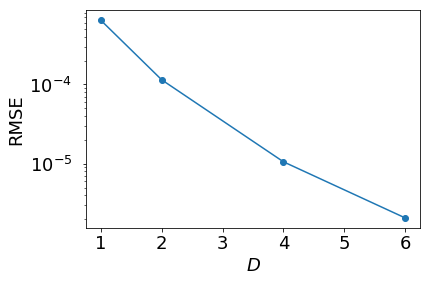

In [45]:
plt.plot(Ds, numpy.sqrt(se_D), marker='o')
plt.xlabel(r'$D$')
plt.ylabel('RMSE')
#plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

In [46]:
#opt_D_idx = 0
D_best = Ds[opt_D_idx]
print("best value of D", D_best)

coeffs = coeffs_D[opt_D_idx].reshape((3, 2, 2, Nl, Nl))
#print(coeffs.shape)
S_2d = S_decomposed[0][:,:,:,:,None] * S_decomposed[1][:,:,:,None,:]
coeffs_gl = (S_2d * coeffs)
print(numpy.abs(coeffs_gl[0,0,0,  0:2,0:2]))
print(numpy.abs(coeffs_gl[0,0,0,  -2:,-2:]))

best value of D 1
[[0.00076954 0.00404385]
 [0.00056386 0.00296304]]
[[7.09541661e-08 2.09212882e-06]
 [3.09660677e-07 9.13054248e-06]]


In [33]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
ax = Axes3D(fig)
X, Y = numpy.meshgrid(numpy.arange(Nl), numpy.arange(Nl))
ax.plot_surface(X, Y, coeffs_gl[0,1,0,:,:].real, cmap='bwr', linewidth=0)
#plt.show()
#fig.colorbar(surf)

In [34]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
def compute_Giwn(prj, coeff):
    niw = prj[0].shape[0]
    #print(prj[0].shape)
    prj_mat = numpy.einsum('nrl,nrm->nrlm', prj[0], prj[1]).reshape((niw, 3 * 2 * 2 * Nl * Nl))
    return prj_mat@coeffs.reshape((3 * 2 * 2 * Nl * Nl))

Giwn_check = compute_Giwn(prj_check, coeffs)
print(Giwn_check.shape)
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(diff)
print(diff < 1e-3)

(3600,)
3.8411893461785556e-05
True


[-1.89638698e-09 -9.59843027e-08 -2.19699838e-07 ... -1.11387669e-07
  8.05726380e-04 -3.86215981e-07]


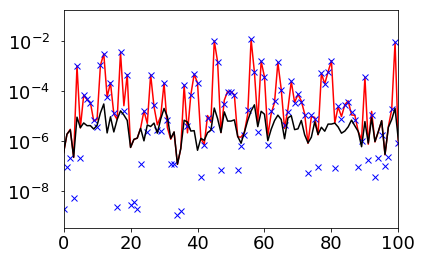

In [35]:
Giwn_reconst = compute_Giwn(prj, coeffs)
#plt.plot(Giwn_reconst.real, c='r')
#plt.plot(Giwn.real)
plt.plot(numpy.abs(Giwn_reconst), c='r')
plt.plot(numpy.abs(Giwn), c='b', ls='', marker='x')
plt.plot(numpy.abs(Giwn-Giwn_reconst), c='k', ls='-', marker='')
plt.yscale("log")
plt.xlim([0,100])
print(Giwn.real)

[-1.89638698e-09 -9.59843027e-08 -2.19699838e-07 ... -1.11387669e-07
  8.05726380e-04 -3.86215981e-07]


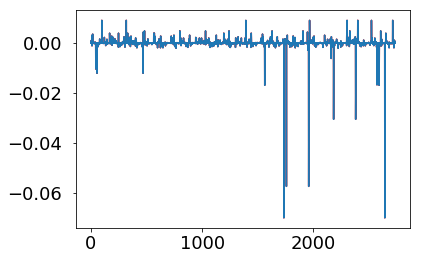

In [36]:
Giwn_reconst = compute_Giwn(prj, coeffs)
plt.plot(Giwn_reconst.real, c='r')
plt.plot(Giwn.real)
print(Giwn.real)

0.07012537833753249


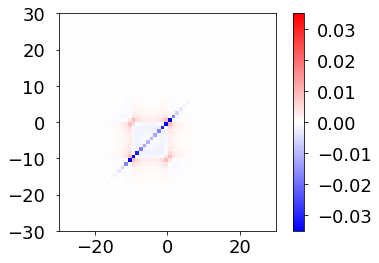

In [37]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 100
N_zoom = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
G2_conn_ph = numpy.zeros((2 * N + 1,2 * N + 1), dtype=float)

for i in range(2 * N + 1):
    for j in range(2 * N + 1):
        n = x[i]
        np = x[j]
        G2_conn_ph[i, j] = _G2_conn_ph(U, beta, n, np, boson_freq)

vrange = numpy.amax(numpy.abs(G2_conn_ph))
plt.imshow(G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()
print (vrange)

#plt.legend(loc='best',shadow=True,frameon=False)

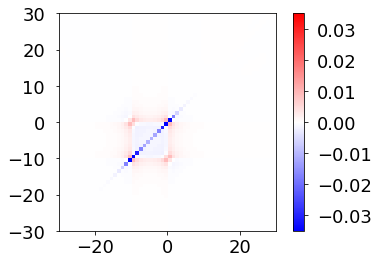

In [38]:
n1n2_check_2d = numpy.array([(x[i], x[j]) for i in range(2 * N + 1) for j in range(2 * N + 1)])
prj_check_2d = construct_prj(n1n2_check_2d)

Giwn_check = compute_Giwn(prj_check_2d, coeffs)
Giwn_check = Giwn_check.reshape((2 * N + 1, 2 * N + 1))
vrange = numpy.amax(numpy.abs(Giwn_check))
plt.imshow(Giwn_check.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()

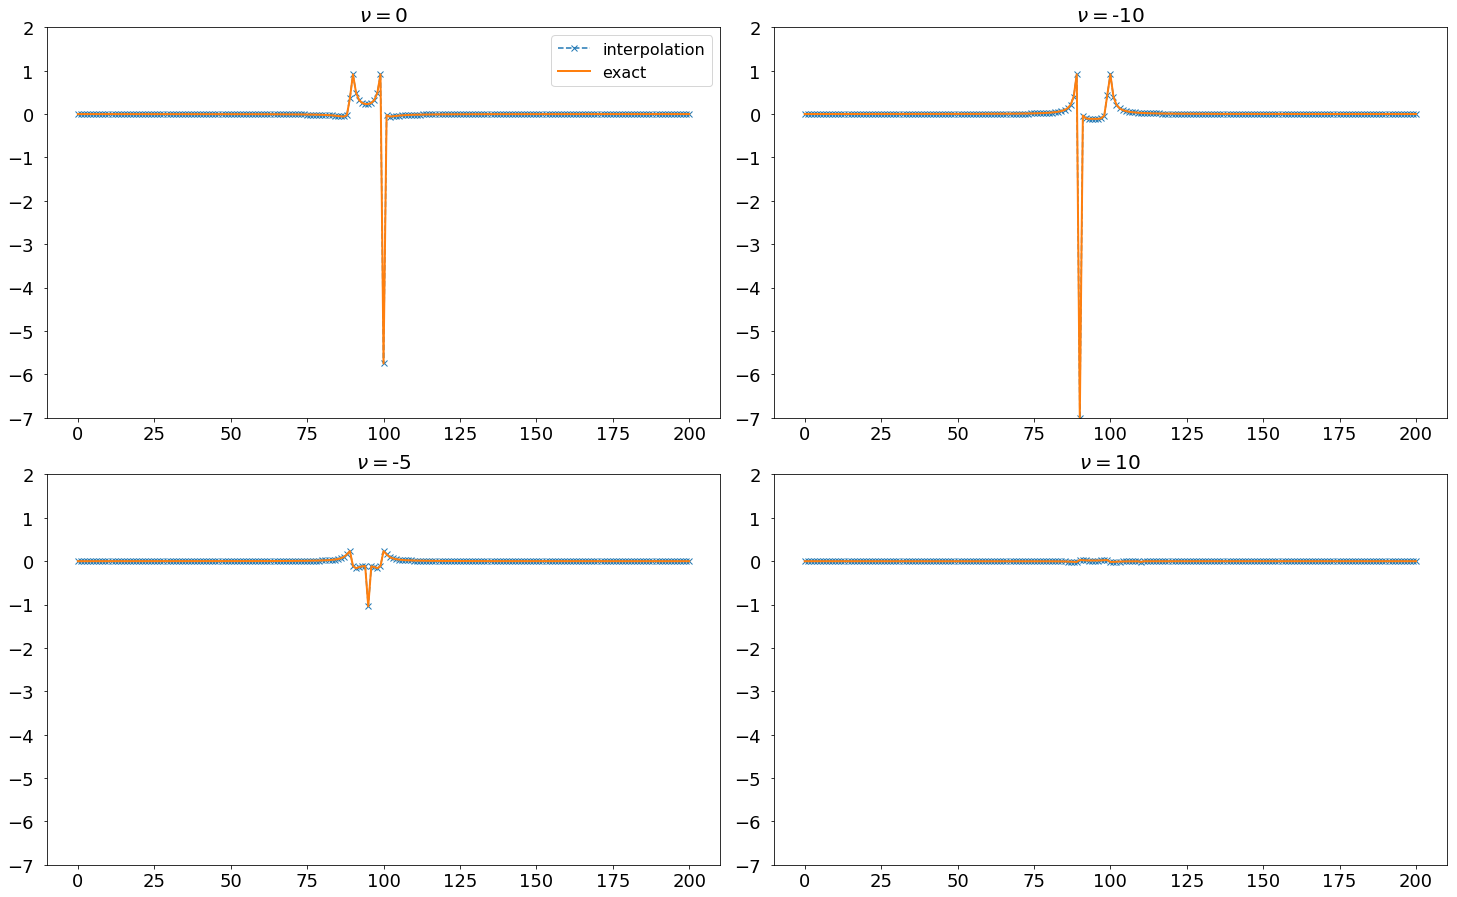

In [39]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_wide.pdf")

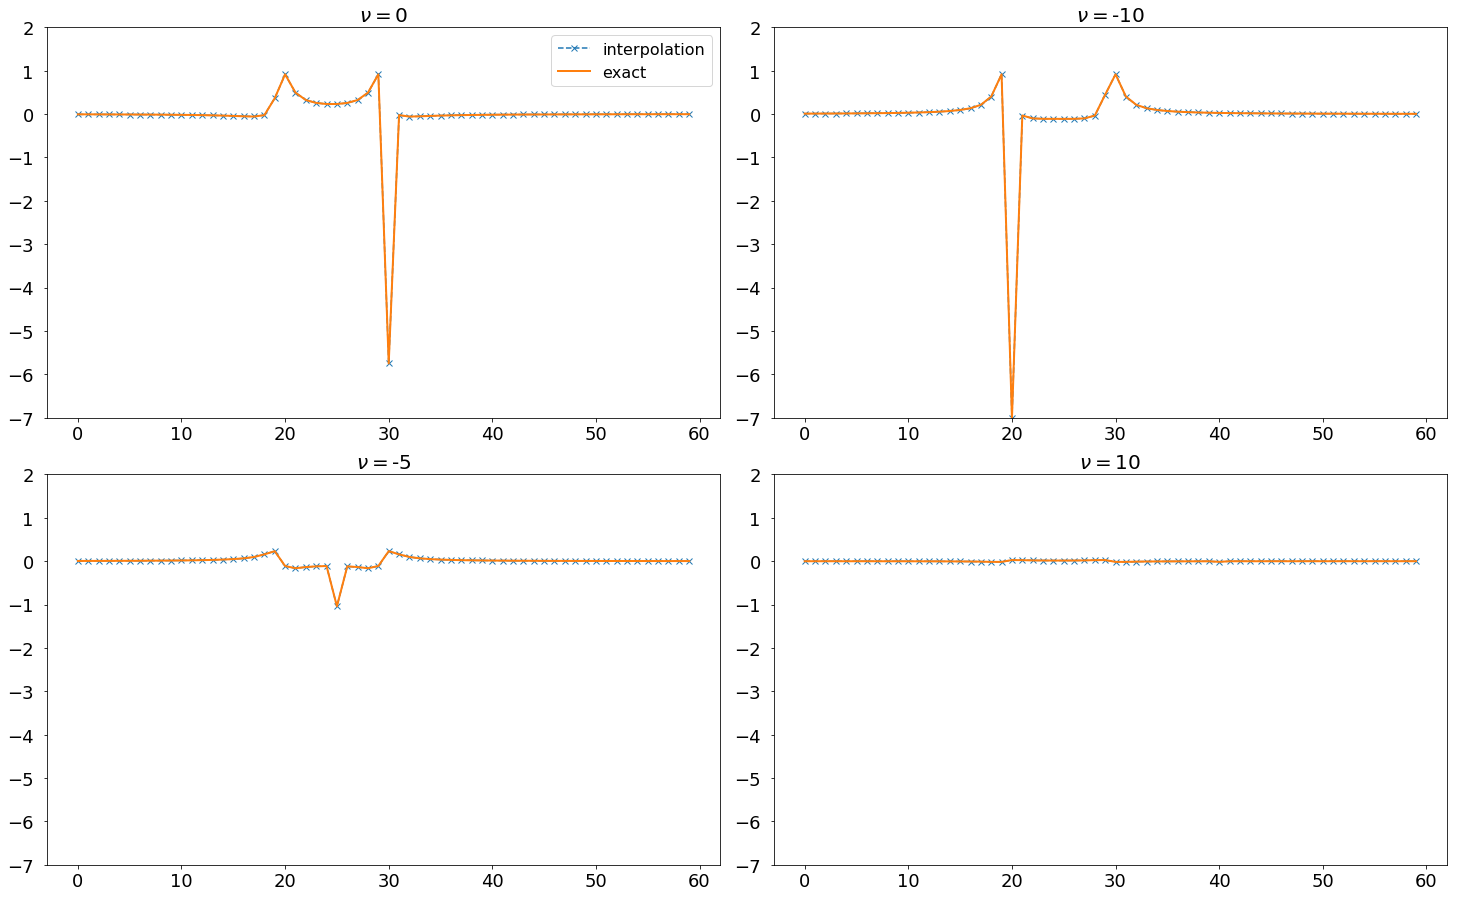

In [40]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_zoom.pdf")